# Monte Carlo Turtle Trading

In this notebook, I explore the performance of the Turtle trading strategy on randomly generated price series. In particular, I explore 2 areas:
1. Using leveraged ETFs vs underlying asset (UPRO vs SPY)
2. Hedging with calls.


In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
import datetime as dt
from utils import misc
import datetime as dt
from trade_obj import *
from simple_backtester import backTester
from mpl_toolkits.mplot3d import Axes3D
import optuna



ticker = 'SPY'
df = pd.read_csv('datasets/stock_price_series/' + ticker + '.csv')
df = misc.clean_df(df)
df = df.set_index('date')

df['ret'] = df['close'].pct_change()

mu = df['ret'].mean()
sigma = df['ret'].std()

print('Daily returns')
print(f'mean: {mu}, vol: {sigma}')

Daily returns
mean: 0.00037208709407292345, vol: 0.011913273091521077


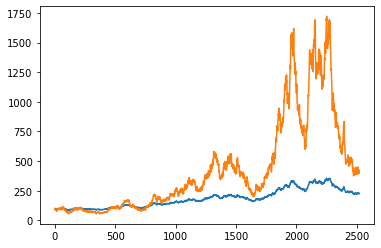

In [2]:
price_series, lev_price_series = misc.generate_price_series_norm(mu, sigma, 100, 2520, 3)
plt.plot(price_series)
plt.plot(lev_price_series)
plt.show()

In [3]:
def generate_price_df(mean, volatility, length, initial_price=100, leverage=3):
    close, lev_close = misc.generate_price_series_norm(
        mean=mean, 
        volatility=volatility, 
        num_days=length, 
        initial_price=initial_price,
        leverage=leverage
        )
    df = pd.DataFrame({
        'open': close,
        'high': close,
        'low': close, 
        'close': close,
        'adjclose': close,
    })

    lev_df = pd.DataFrame({
        'open': lev_close,
        'high': lev_close,
        'low': lev_close, 
        'close': lev_close,
        'adjclose': lev_close,
    })


    return df, lev_df

    

Modify the indicator and trading strategy to use 1 price per day.

In [4]:
def generate_high_low(df, high_window, low_window):

    df['up_bound'] = df['close'].shift(1).rolling(high_window).max()
    df['low_bound'] = df['close'].shift(1).rolling(low_window).min()

    return df

def generate_atr(df, window):
    df['TR'] = abs(df['close'] - df['close'].shift(1))
    df['ATR'] = df['TR'].rolling(window).mean()
    return df



In [5]:
def hatr_backtest(df, high_window, low_window, atr_window, atr_multiple):

    df = generate_high_low(df, high_window=high_window, low_window=low_window)
    df = generate_atr(df, atr_window)

    df['ATR'] = df['ATR'].shift(1)
    

    df.dropna(inplace=True)
    atr = df['ATR'].to_numpy()

    df['signal'] = 0

    # Generate trading signals
    df.loc[df['close'].shift(1) > df['up_bound'].shift(2), 'signal'] = 1    

    trades_arr = df['signal'].to_numpy()

    bt = backTester()
    bt.set_asset(df)

    tl = tradeList()

    open_trade = None
    stop_loss = np.nan
    stop_arr = []
    

    for i in range(len(bt.df)):
        
        order_quantity = 0
        order_price = 0
        

        if trades_arr[i] == 1 and open_trade == None:
    
            # order price at breakout
            order_price = bt.close[i]
            # order 1 unit
            order_quantity = bt.cash // order_price
            # open trade on record
            open_trade = trade(bt.date[i], order_price, order_quantity)
            n3 = atr_multiple * atr[i]
            stop_loss = order_price - n3
            
        # open trades present 
        elif open_trade != None:
            stop_loss = max(stop_loss, bt.close[i - 1] - n3, df['low_bound'].to_numpy()[i])
            if bt.low[i] < stop_loss:

                order_price = stop_loss
                order_quantity = -open_trade.quantity
                    
                open_trade.close(bt.date[i], order_price)
                tl.append(open_trade)
                
                open_trade = None
                stop_loss = np.nan
        
        stop_arr.append(stop_loss)

        bt.take_action(order_quantity=order_quantity, order_price=order_price)
    bt.df['stop_loss'] = stop_arr

    return bt, tl

sharpe: strat 0.5692812071993618, buy_hold 0.051247337349970744, diff 0.518033869849391
return: strat 0.06393695594843884, buy_hold 0.009614972833867919, diff 0.054321983114570926


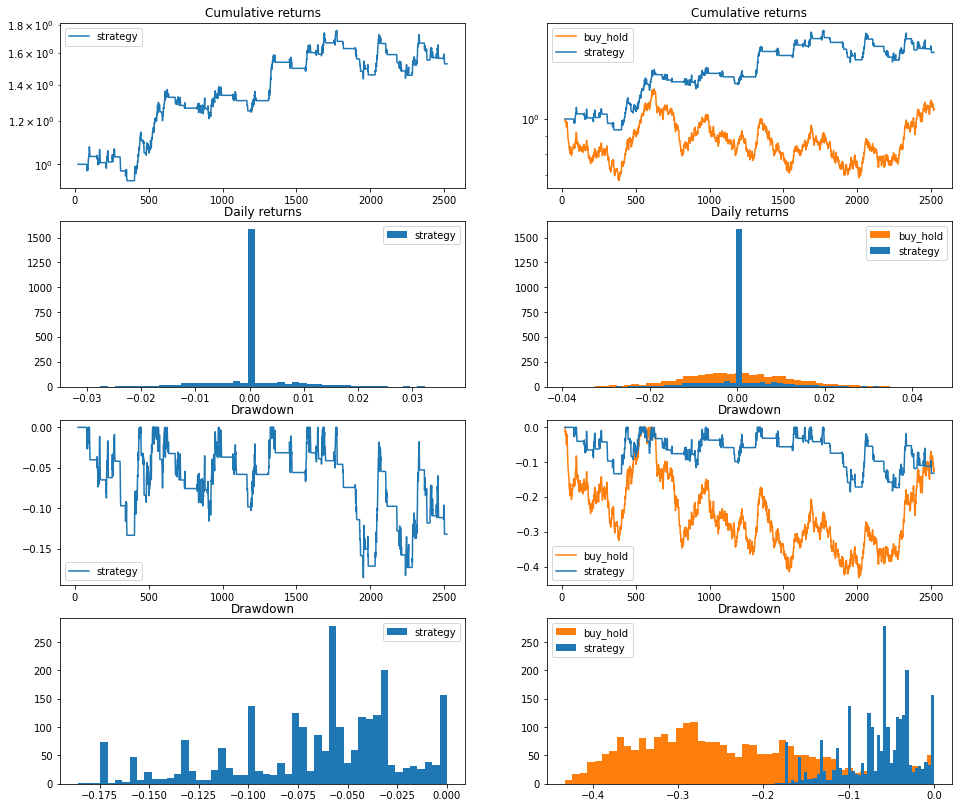

In [6]:
df, lev_df = generate_price_df(mean=mu, volatility=sigma, length=2520)

bt, tl = hatr_backtest(df, 20, 20, 20, 5)
bt.analyse()

print(f'sharpe: strat {bt.sharpe}, buy_hold {bt.buy_hold_sharpe}, diff {bt.sharpe - bt.buy_hold_sharpe}')
print(f'return: strat {bt.annual_return}, buy_hold {bt.buy_hold_annual_return}, diff {bt.annual_return - bt.buy_hold_annual_return}')
bt.plot_graphs()

sharpe: strat 6.872280707394389, buy_hold -0.11618738655731654, diff 6.988468093951706
return: strat 3.480147507648507, buy_hold -0.09564856214661166, diff 3.5757960697951185


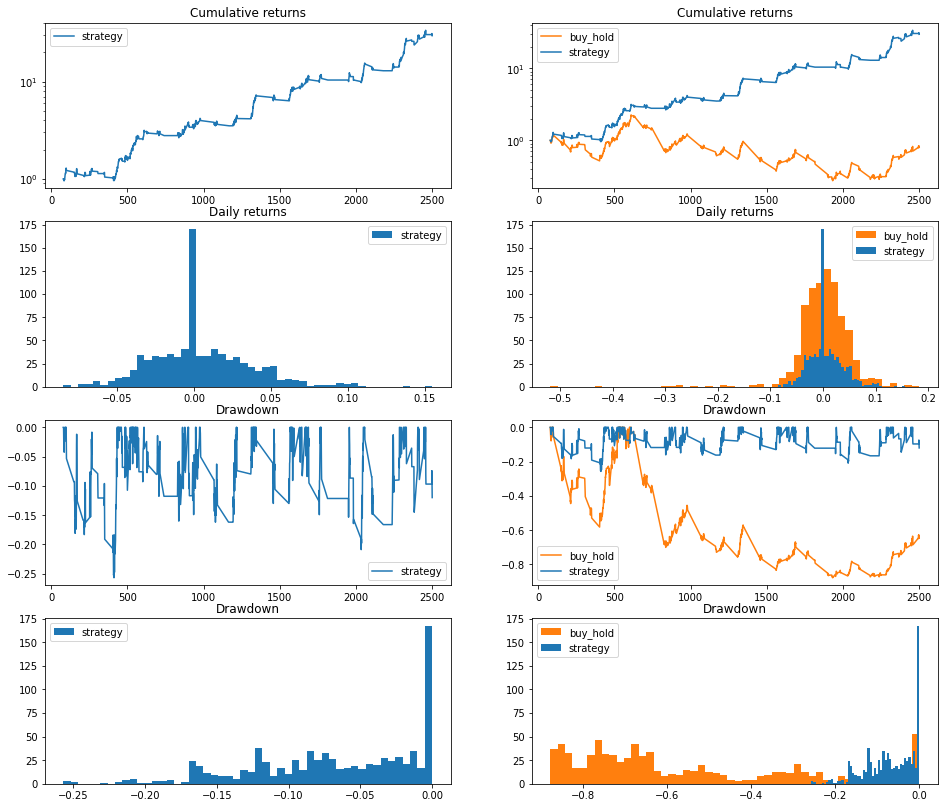

In [23]:
bt, tl = hatr_backtest(lev_df, 20, 20, 20, 5)
bt.analyse()
print(f'sharpe: strat {bt.sharpe}, buy_hold {bt.buy_hold_sharpe}, diff {bt.sharpe - bt.buy_hold_sharpe}')
print(f'return: strat {bt.annual_return}, buy_hold {bt.buy_hold_annual_return}, diff {bt.annual_return - bt.buy_hold_annual_return}')
bt.plot_graphs()

In [27]:
num_trials = 10000

ret = []
vol = []
sharpe = []

lret = []
lvol = []
lsharpe = []

for i in range(num_trials):
    df, lev_df = generate_price_df(mean=mu, volatility=sigma, length=2520)

    bt, _ = hatr_backtest(df, 20, 20, 20, 5)
    bt.analyse()

    # ret.append(bt.annual_return - bt.buy_hold_annual_return)
    # vol.append(bt.annual_vol - bt.buy_hold_annual_vol)
    # sharpe.append(bt.sharpe - bt.buy_hold_sharpe)

    ret.append(bt.annual_return)
    vol.append(bt.annual_vol)
    sharpe.append(bt.sharpe)


    bt, _ = hatr_backtest(lev_df, 20, 20, 20, 5)
    bt.analyse()

    # lret.append(bt.annual_return - bt.buy_hold_annual_return)
    # lvol.append(bt.annual_vol - bt.buy_hold_annual_vol)
    # lsharpe.append(bt.sharpe - bt.buy_hold_sharpe)

    lret.append(bt.annual_return)
    lvol.append(bt.annual_vol)
    lsharpe.append(bt.sharpe)

ret = np.array(ret)
vol = np.array(vol)
sharpe = np.array(sharpe)
lret = np.array(lret)
lvol = np.array(lvol)
lsharpe = np.array(lsharpe)

print(f'average ret: {np.mean(ret)}')
print(f'average lret: {np.mean(lret)}')
print(f'average ret - lret: {np.mean(ret - lret)}')

print(f'average vol: {np.mean(vol)}')
print(f'average lvol: {np.mean(lvol)}')
print(f'average vol - lvol: {np.mean(vol - lvol)}')

print(f'average sharpe: {np.mean(sharpe)}')
print(f'average lsharpe: {np.mean(lsharpe)}')
print(f'average sharpe - lsharpe: {np.mean(sharpe - lsharpe)}')   

average ret: 0.10341543584693691
average lret: 0.2699498069764547
average ret - lret: -0.16653437112951774
average vol: 0.12171646160508297
average lvol: 0.3435336790038164
average vol - lvol: -0.22181721739873342
average sharpe: 0.8340153493508548
average lsharpe: 0.7687745327894483
average sharpe - lsharpe: 0.06524081656140637


In [ ]:
num_trials = 10000

ret = []
vol = []
sharpe = []

lret = []
lvol = []
lsharpe = []

for i in range(num_trials):
    df, lev_df = generate_price_df(mean=mu, volatility=sigma, length=2520)

    bt, _ = hatr_backtest(df, 20, 20, 20, 5)
    bt.analyse()

    # ret.append(bt.annual_return - bt.buy_hold_annual_return)
    # vol.append(bt.annual_vol - bt.buy_hold_annual_vol)
    # sharpe.append(bt.sharpe - bt.buy_hold_sharpe)

    ret.append(bt.annual_return)
    vol.append(bt.annual_vol)
    sharpe.append(bt.sharpe)


    bt, _ = hatr_backtest(lev_df, 20, 20, 20, 5)
    bt.analyse()

    # lret.append(bt.annual_return - bt.buy_hold_annual_return)
    # lvol.append(bt.annual_vol - bt.buy_hold_annual_vol)
    # lsharpe.append(bt.sharpe - bt.buy_hold_sharpe)

    lret.append(bt.annual_return)
    lvol.append(bt.annual_vol)
    lsharpe.append(bt.sharpe)

ret = np.array(ret)
vol = np.array(vol)
sharpe = np.array(sharpe)
lret = np.array(lret)
lvol = np.array(lvol)
lsharpe = np.array(lsharpe)

print(f'average ret: {np.mean(ret)}')
print(f'average lret: {np.mean(lret)}')
print(f'average ret - lret: {np.mean(ret - lret)}')

print(f'average vol: {np.mean(vol)}')
print(f'average lvol: {np.mean(lvol)}')
print(f'average vol - lvol: {np.mean(vol - lvol)}')

print(f'average sharpe: {np.mean(sharpe)}')
print(f'average lsharpe: {np.mean(lsharpe)}')
print(f'average sharpe - lsharpe: {np.mean(sharpe - lsharpe)}')  

In [8]:


def objective(trial):
    # Define the parameters to optimize
    h_wind = trial.suggest_int('high_window', 5, 200)
    l_wind = trial.suggest_int('low_window', 5, 200)
    atr_wind = trial.suggest_int('atr_window', 5, 100)
    atr_mult = trial.suggest_int('atr_multiple', 1, 10)
    
    # Call your function with the chosen parameters
    bt, _ = hatr_backtest(
            df.copy(), 
            high_window=h_wind, 
            low_window=l_wind, 
            atr_window=atr_wind, 
            atr_multiple=atr_mult
            )
    
    bt.analyse()
    # Define the objective to minimize or maximize (e.g., error or loss)
    objective_value = bt.sharpe  # Assuming you want to maximize the result
    
    return objective_value

# Create an Optuna study
study = optuna.create_study(direction='maximize')

# Run the optimization process
study.optimize(objective, n_trials=200)

# Get the best parameters and objective value
best_params = study.best_params
best_value = study.best_value

print("Best Parameters:", best_params)
print("Best Value:", best_value)


[I 2023-07-11 17:18:18,929] A new study created in memory with name: no-name-ebf8259c-1f99-470f-af22-0adda6e77aee
[I 2023-07-11 17:18:18,958] Trial 0 finished with value: 4.069842733660451 and parameters: {'high_window': 62, 'low_window': 99, 'atr_window': 91, 'atr_multiple': 1}. Best is trial 0 with value: 4.069842733660451.
[I 2023-07-11 17:18:18,986] Trial 1 finished with value: 2.5268018783777118 and parameters: {'high_window': 39, 'low_window': 97, 'atr_window': 61, 'atr_multiple': 7}. Best is trial 0 with value: 4.069842733660451.
[I 2023-07-11 17:18:19,014] Trial 2 finished with value: 2.124035362477068 and parameters: {'high_window': 95, 'low_window': 65, 'atr_window': 67, 'atr_multiple': 9}. Best is trial 0 with value: 4.069842733660451.
[I 2023-07-11 17:18:19,033] Trial 3 finished with value: 1.8720968965846718 and parameters: {'high_window': 192, 'low_window': 193, 'atr_window': 89, 'atr_multiple': 8}. Best is trial 0 with value: 4.069842733660451.
[I 2023-07-11 17:18:19,054

Best Parameters: {'high_window': 8, 'low_window': 194, 'atr_window': 38, 'atr_multiple': 1}
Best Value: 5.01948402310235


### Effects of High/Low Window

In [9]:
hl_period = np.arange(5, 201, 5)
results = []

for i in range(len(hl_period)):
    for j in range(len(hl_period)):
        # print(i, j)
        bt, _ = hatr_backtest(
            df.copy(), 
            high_window=hl_period[i], 
            low_window=hl_period[j], 
            atr_window=best_params['atr_window'], 
            atr_multiple=best_params['atr_multiple']
            )
        bt.analyse()
        results.append((hl_period[i], hl_period[j], bt.annual_return, bt.annual_vol, bt.sharpe))

In [10]:
print('Buy Hold Results')
print(f'Annual Return = {bt.buy_hold_annual_return}')
print(f'Annual Volatility = {bt.buy_hold_annual_vol}')
print(f'Sharpe Ratio = {bt.buy_hold_sharpe}')
print('-----------')
best_sr = max(results, key=lambda x: x[2])
print(f'Max Total Returns:')
print(f'High Window = {best_sr[0]}, Low Window = {best_sr[1]}')
print(f'Annual Return = {best_sr[2]}')
print(f'Annual Volatility = {best_sr[3]}')
print(f'Sharpe Ratio = {best_sr[4]}')
print('-----------')
best_sr = max(results, key=lambda x: x[4])
print(f'Max Sharpe Ratio:')
print(f'High Window = {best_sr[0]}, Low Window = {best_sr[1]}')
print(f'Annual Return = {best_sr[2]}')
print(f'Annual Volatility = {best_sr[3]}')
print(f'Sharpe Ratio = {best_sr[4]}')
print('-----------')


Buy Hold Results
Annual Return = 0.12932172051662416
Annual Volatility = 0.27003312642520705
Sharpe Ratio = 0.4789105774859193
-----------
Max Total Returns:
High Window = 10, Low Window = 195
Annual Return = 0.4555915177557093
Annual Volatility = 0.09270249425158693
Sharpe Ratio = 4.91455511994393
-----------
Max Sharpe Ratio:
High Window = 10, Low Window = 195
Annual Return = 0.4555915177557093
Annual Volatility = 0.09270249425158693
Sharpe Ratio = 4.91455511994393
-----------


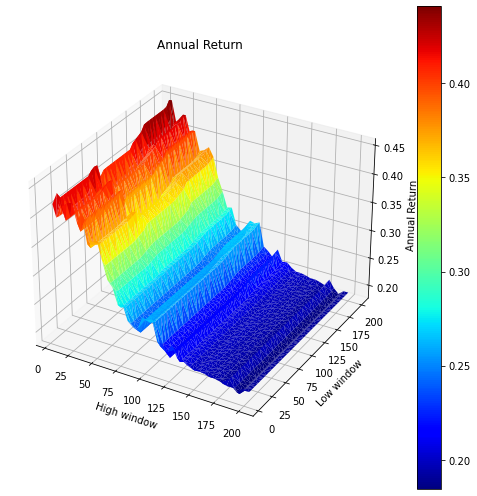

In [11]:
x = np.array([f[0] for f in results])
y = np.array([f[1] for f in results])
z = np.array([f[2] for f in results])

fig = plt.figure(figsize=(7, 7))
ax = fig.add_subplot(111, projection='3d')

surf = ax.plot_trisurf(x, y, z, cmap='jet', linewidth=0)
fig.colorbar(surf)

# Set labels and title
ax.set_xlabel('High window')
ax.set_ylabel('Low window')
ax.set_zlabel('Annual Return')
ax.set_title('Annual Return')

fig.tight_layout()

plt.show()

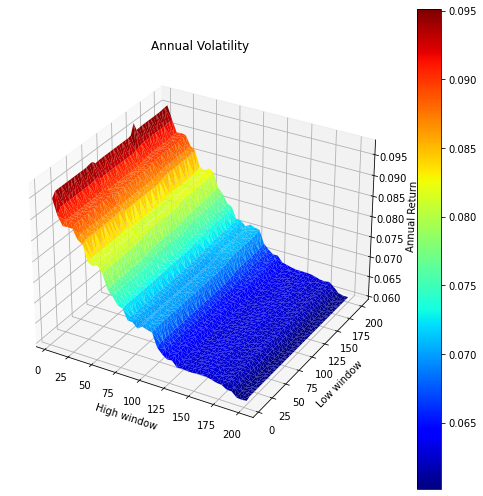

In [12]:
x = np.array([f[0] for f in results])
y = np.array([f[1] for f in results])
z = np.array([f[3] for f in results])

fig = plt.figure(figsize=(7, 7))
ax = fig.add_subplot(111, projection='3d')

surf = ax.plot_trisurf(x, y, z, cmap='jet', linewidth=0)
fig.colorbar(surf)

# Set labels and title
ax.set_xlabel('High window')
ax.set_ylabel('Low window')
ax.set_zlabel('Annual Return')
ax.set_title('Annual Volatility')

fig.tight_layout()

plt.show()

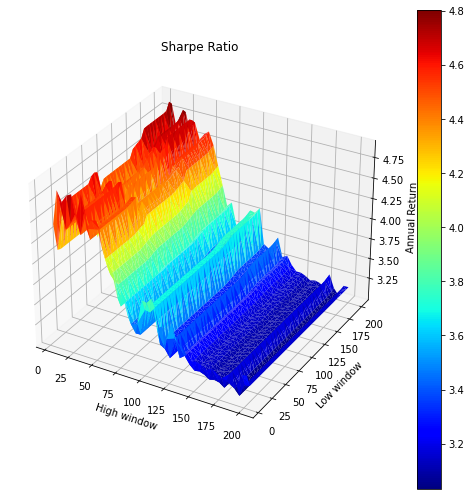

In [13]:
x = np.array([f[0] for f in results])
y = np.array([f[1] for f in results])
z = np.array([f[4] for f in results])

fig = plt.figure(figsize=(7, 7))
ax = fig.add_subplot(111, projection='3d')

surf = ax.plot_trisurf(x, y, z, cmap='jet', linewidth=0)
fig.colorbar(surf)

# Set labels and title
ax.set_xlabel('High window')
ax.set_ylabel('Low window')
ax.set_zlabel('Annual Return')
ax.set_title('Sharpe Ratio')

fig.tight_layout()

plt.show()

### Effects of ATR multiple and ATR window

In [14]:
atr_window_range = np.arange(5, 101, 5)
atr_multiple_range = np.arange(1, 11, 1)
results = []

for i in range(len(atr_window_range)):
    for j in range(len(atr_multiple_range)):
        # print(i, j)
        bt, _ = hatr_backtest(
            df.copy(), 
            high_window=best_params['high_window'], 
            low_window=best_params['low_window'], 
            atr_window=atr_window_range[i], 
            atr_multiple=atr_multiple_range[j]
            )
        bt.analyse()
        results.append((atr_window_range[i], atr_multiple_range[j], bt.annual_return, bt.annual_vol, bt.sharpe))

In [15]:
print('Buy Hold Results')
print(f'Annual Return = {bt.buy_hold_annual_return}')
print(f'Annual Volatility = {bt.buy_hold_annual_vol}')
print(f'Sharpe Ratio = {bt.buy_hold_sharpe}')
print('-----------')
best_sr = max(results, key=lambda x: x[2])
print(f'Max Total Returns:')
print(f'ATR Window = {best_sr[0]}, ATR multiple = {best_sr[1]}')
print(f'Annual Return = {best_sr[2]}')
print(f'Annual Volatility = {best_sr[3]}')
print(f'Sharpe Ratio = {best_sr[4]}')
print('-----------')
best_sr = max(results, key=lambda x: x[4])
print(f'Max Sharpe Ratio:')
print(f'ATR Window = {best_sr[0]}, ATR multiple = {best_sr[1]}')
print(f'Annual Return = {best_sr[2]}')
print(f'Annual Volatility = {best_sr[3]}')
print(f'Sharpe Ratio = {best_sr[4]}')
print('-----------')

Buy Hold Results
Annual Return = 0.14265687887032596
Annual Volatility = 0.2694521476081524
Sharpe Ratio = 0.5294330742458325
-----------
Max Total Returns:
ATR Window = 65, ATR multiple = 7
Annual Return = 0.6167149157740517
Annual Volatility = 0.19315429614323817
Sharpe Ratio = 3.192861500303944
-----------
Max Sharpe Ratio:
ATR Window = 55, ATR multiple = 1
Annual Return = 0.47310286820898617
Annual Volatility = 0.09318031579354473
Sharpe Ratio = 5.077283374497443
-----------


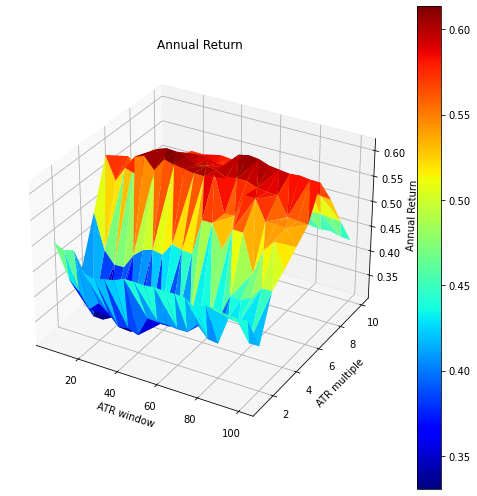

In [16]:
x = np.array([f[0] for f in results])
y = np.array([f[1] for f in results])
z = np.array([f[2] for f in results])

fig = plt.figure(figsize=(7, 7))
ax = fig.add_subplot(111, projection='3d')

surf = ax.plot_trisurf(x, y, z, cmap='jet', linewidth=0)
fig.colorbar(surf)

# Set labels and title
ax.set_xlabel('ATR window')
ax.set_ylabel('ATR multiple')
ax.set_zlabel('Annual Return')
ax.set_title('Annual Return')

fig.tight_layout()

plt.show()

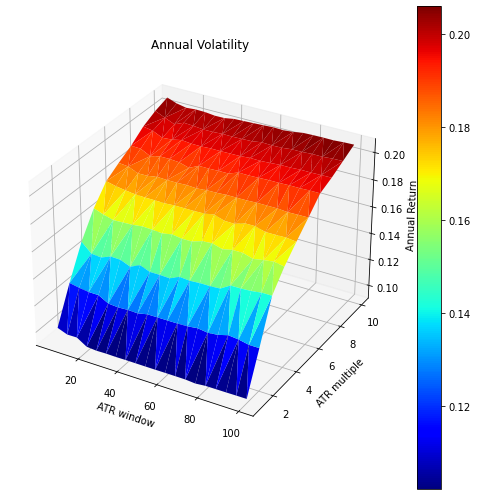

In [17]:
x = np.array([f[0] for f in results])
y = np.array([f[1] for f in results])
z = np.array([f[3] for f in results])

fig = plt.figure(figsize=(7, 7))
ax = fig.add_subplot(111, projection='3d')

surf = ax.plot_trisurf(x, y, z, cmap='jet', linewidth=0)
fig.colorbar(surf)

# Set labels and title
ax.set_xlabel('ATR window')
ax.set_ylabel('ATR multiple')
ax.set_zlabel('Annual Return')
ax.set_title('Annual Volatility')

fig.tight_layout()

plt.show()

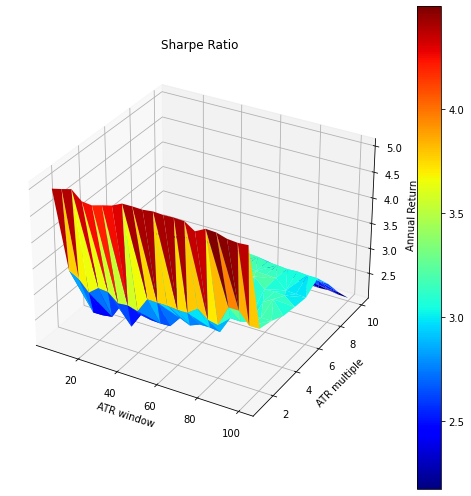

In [18]:
x = np.array([f[0] for f in results])
y = np.array([f[1] for f in results])
z = np.array([f[4] for f in results])

fig = plt.figure(figsize=(7, 7))
ax = fig.add_subplot(111, projection='3d')

surf = ax.plot_trisurf(x, y, z, cmap='jet', linewidth=0)
fig.colorbar(surf)

# Set labels and title
ax.set_xlabel('ATR window')
ax.set_ylabel('ATR multiple')
ax.set_zlabel('Annual Return')
ax.set_title('Sharpe Ratio')

fig.tight_layout()

plt.show()

### Portfolio Stats

This section looks at the stats of a portfolio that runs this trade at no leverage.

This portfolio has lower returns and lower volatility/drawdowns compared to a buy-hold strategy. The portfolio manages to avoid the large drawdown events, thus preserving capital.

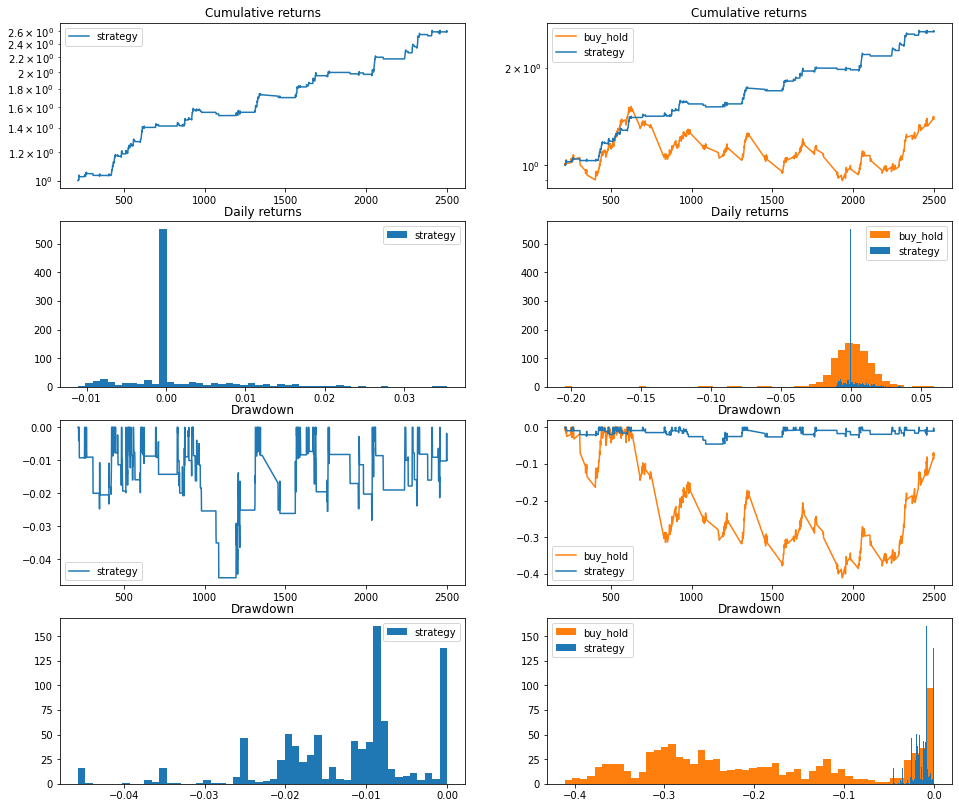

In [19]:
bt, tl = hatr_backtest(
    df.copy(), 
    high_window=best_params['high_window'], 
    low_window=best_params['low_window'], 
    atr_window=best_params['atr_window'], 
    atr_multiple=best_params['atr_multiple'])

bt.analyse()
bt.plot_graphs()

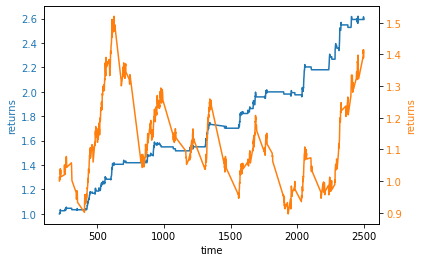

In [20]:
fig, ax1 = plt.subplots()

color = 'C0'
ax1.set_xlabel('time')
ax1.set_ylabel('returns', color=color)
ax1.plot(bt.date, bt.records['cum_returns'], color=color)
ax1.tick_params(axis='y', labelcolor=color)

color = 'C1'
ax2 = ax1.twinx()
ax2.set_ylabel('returns', color=color)
ax2.plot(bt.date, bt.records['buy_hold_cum_returns'], color=color)
ax2.tick_params(axis='y', labelcolor=color)

ax1.set_facecolor('xkcd:white')
plt.show()

In [21]:
print(f'Annualised return:          {bt.annual_return}')
print(f'buy_hold annual return:     {bt.buy_hold_annual_return}')
print('---------')
print(f'Annualised vol:             {bt.annual_vol}')
print(f'buy_hold annual vol:        {bt.buy_hold_annual_vol}')
print('---------')
print(f'Sharpe ratio:               {bt.sharpe}')
print(f'buy_hold Sharpe ratio:      {bt.buy_hold_sharpe}')

Annualised return:          0.4688557474944641
buy_hold annual return:     0.14265687887032596
---------
Annualised vol:             0.09340716004604044
buy_hold annual vol:        0.2694521476081524
---------
Sharpe ratio:               5.01948402310235
buy_hold Sharpe ratio:      0.5294330742458325


### Trade record stats

This section looks at the backtest results on a trade-by-trade basis.

In [22]:
tl.analyse(bt.df)
tl.stats

AttributeError: 'int' object has no attribute 'days'

We plot every single trade to view the characteristics of each trade.

trade 0
entry: [1.9995830059051516]
cost_basis: 1.9995830059051516
exit: 2.4882866541544595
returns: 0.24440278138295457


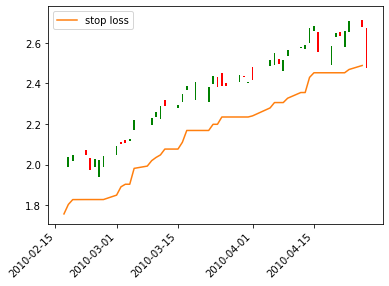

trade 1
entry: [1.8477779626846316]
cost_basis: 1.8477779626846318
exit: 1.70157523949941
returns: -0.07912353439522805


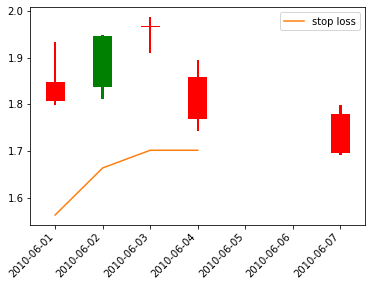

trade 2
entry: [1.9306939840316768]
cost_basis: 1.9306939840316768
exit: 1.6931006908416746
returns: -0.12306108329703275


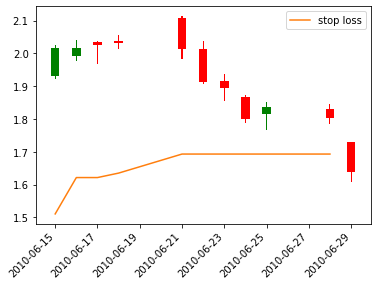

trade 3
entry: [1.774027943611145]
cost_basis: 1.774027943611145
exit: 1.705370585123698
returns: -0.03870139629688734


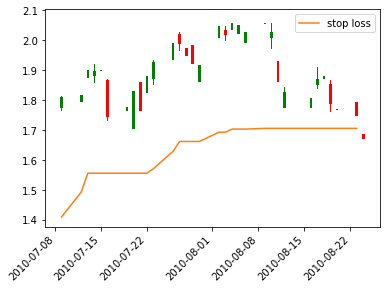

trade 4
entry: [1.816944003105164]
cost_basis: 1.816944003105164
exit: 3.0289337635040283
returns: 0.6670484936946705


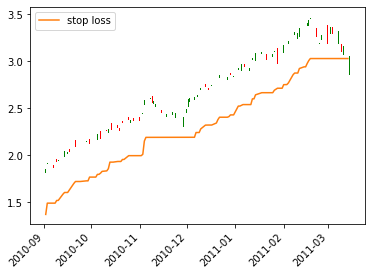

trade 5
entry: [3.2174999713897705]
cost_basis: 3.2174999713897705
exit: 3.287779013315837
returns: 0.02184274826759671


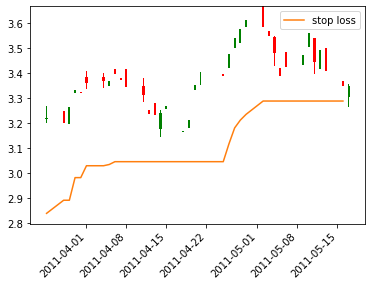

trade 6
entry: [3.4362499713897705]
cost_basis: 3.4362499713897705
exit: 3.051157553990682
returns: -0.1120676378626029


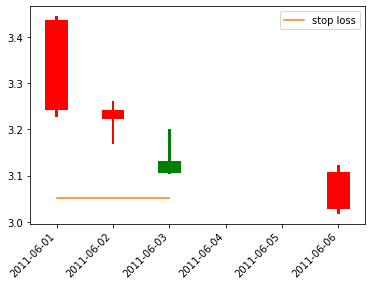

trade 7
entry: [3.0625]
cost_basis: 3.0625
exit: 3.187407573064169
returns: 0.04078614630666739


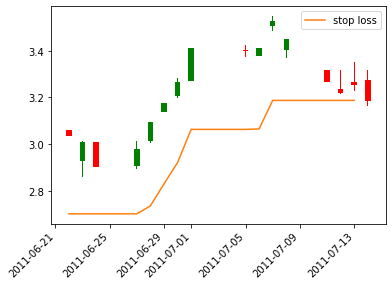

trade 8
entry: [3.44333291053772]
cost_basis: 3.44333291053772
exit: 3.221852382024129
returns: -0.06432155538483912


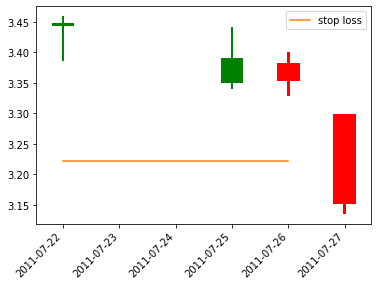

trade 9
entry: [2.3399999141693115]
cost_basis: 2.3399999141693115
exit: 2.0129625797271733
returns: -0.13975954975974214


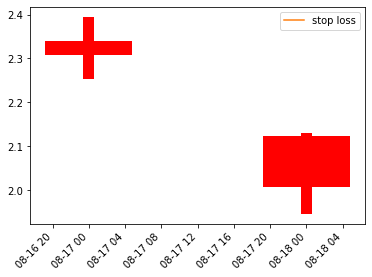

trade 10
entry: [2.2699999809265137]
cost_basis: 2.2699999809265137
exit: 2.131018797556559
returns: -0.061225191426313844


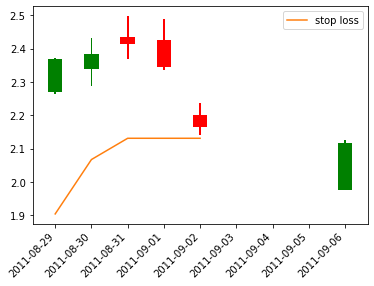

trade 11
entry: [2.377500057220459]
cost_basis: 2.377500057220459
exit: 2.065785964330037
returns: -0.1311100253998932


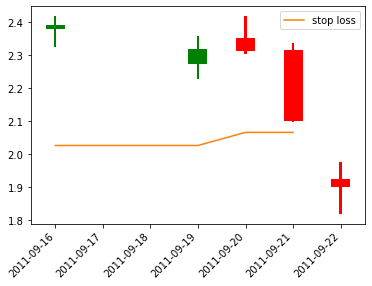

trade 12
entry: [2.188750028610229]
cost_basis: 2.188750028610229
exit: 2.2597688833872476
returns: 0.032447220490552195


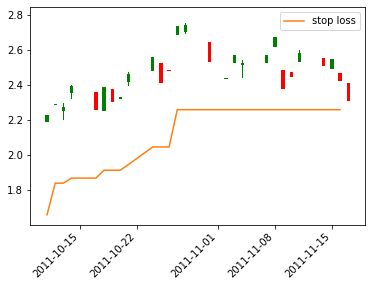

trade 13
entry: [2.440417051315308]
cost_basis: 2.440417051315308
exit: 3.244028488794962
returns: 0.3292926662049556


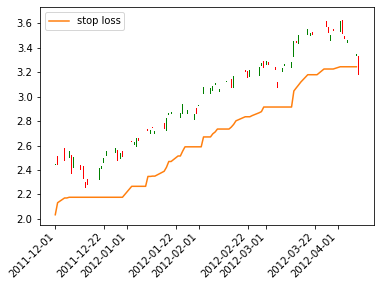

trade 14
entry: [3.3566670417785645]
cost_basis: 3.3566670417785645
exit: 2.9304170608520503
returns: -0.12698607744563822


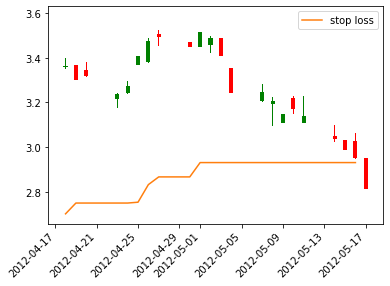

trade 15
entry: [2.922499895095825]
cost_basis: 2.922499895095825
exit: 3.448334058125814
returns: 0.17992615291873168


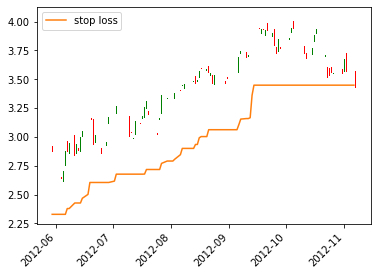

trade 16
entry: [3.3804171085357666]
cost_basis: 3.3804171085357666
exit: 4.641805013020834
returns: 0.3731456397200166


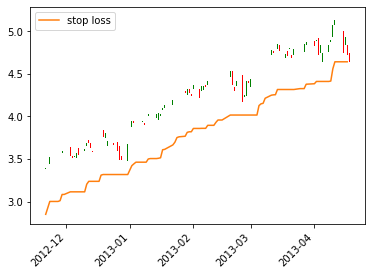

trade 17
entry: [5.019583225250244]
cost_basis: 5.019583225250244
exit: 5.74222183227539
returns: 0.14396386604171096


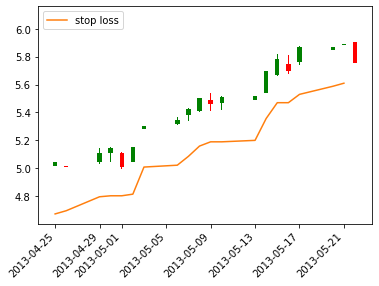

trade 18
entry: [5.574999809265137]
cost_basis: 5.574999809265137
exit: 5.547361532847086
returns: -0.0049575385405607455


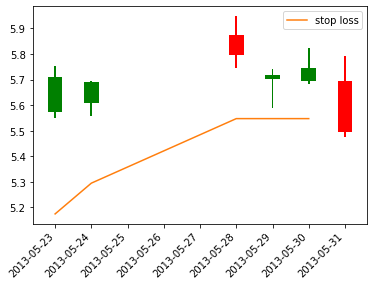

trade 19
entry: [5.69083309173584]
cost_basis: 5.69083309173584
exit: 5.071388721466064
returns: -0.10884950591317219


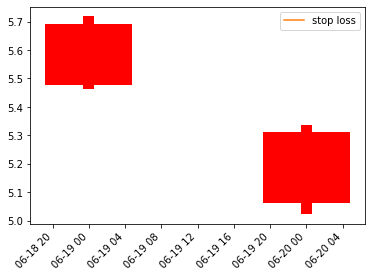

trade 20
entry: [5.297500133514404]
cost_basis: 5.297500133514404
exit: 5.742499669392903
returns: 0.08400179795432733


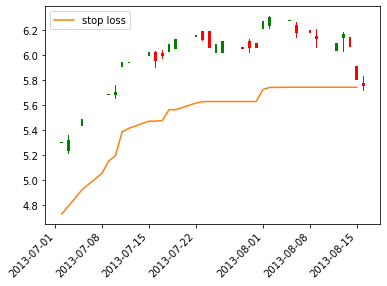

trade 21
entry: [5.586667060852051]
cost_basis: 5.586667060852051
exit: 6.259721914927164
returns: 0.12047520404275933


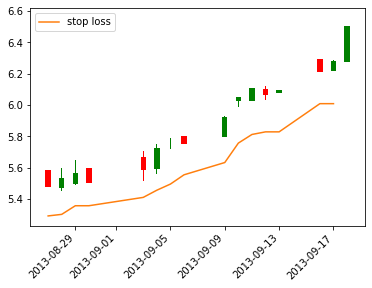

trade 22
entry: [6.558332920074463]
cost_basis: 6.558332920074463
exit: 6.133610566457114
returns: -0.06476071873651186


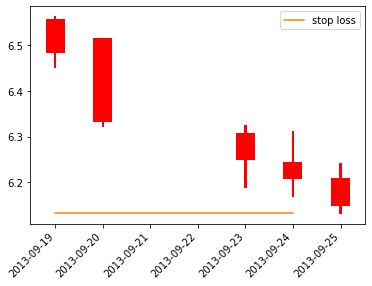

trade 23
entry: [6.140832901000977]
cost_basis: 6.140832901000977
exit: 7.101388613382976
returns: 0.1564210796593122


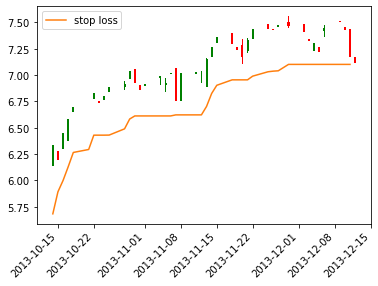

trade 24
entry: [7.46750020980835]
cost_basis: 7.46750020980835
exit: 7.571667353312175
returns: 0.013949399474673543


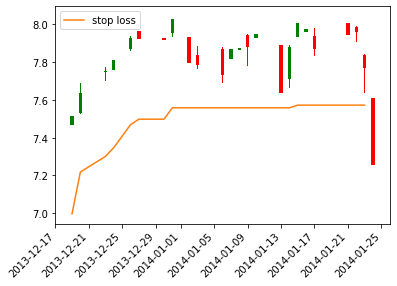

trade 25
entry: [7.389999866485596]
cost_basis: 7.389999866485596
exit: 7.977778116861979
returns: 0.07953697713067862


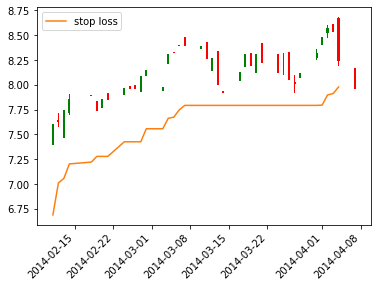

trade 26
entry: [8.382499694824219]
cost_basis: 8.382499694824219
exit: 9.479167302449545
returns: 0.13082823114237205


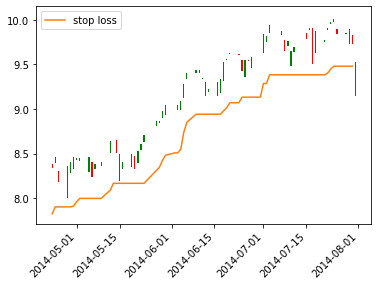

trade 27
entry: [9.204999923706056]
cost_basis: 9.204999923706056
exit: 9.89888827006022
returns: 0.07538167866434871


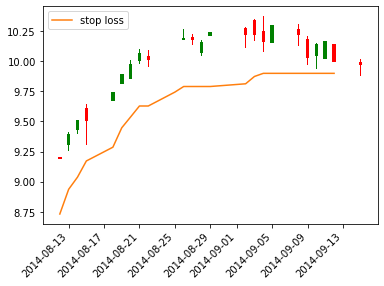

trade 28
entry: [10.324167251586914]
cost_basis: 10.324167251586914
exit: 9.44138813018799
returns: -0.08550608488672375


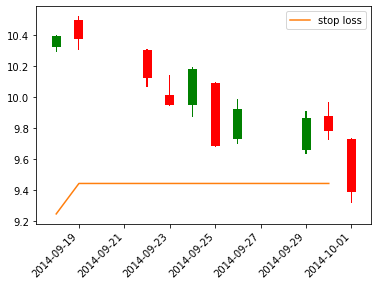

trade 29
entry: [9.320833206176758]
cost_basis: 9.320833206176758
exit: 10.438610712687174
returns: 0.11992248780609913


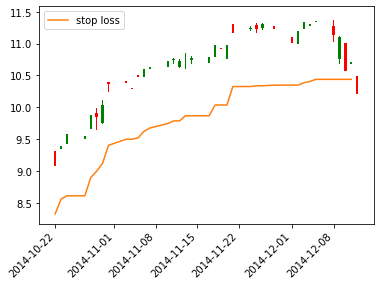

trade 30
entry: [11.214166641235352]
cost_basis: 11.214166641235352
exit: 10.830833435058594
returns: -0.034182941848501895


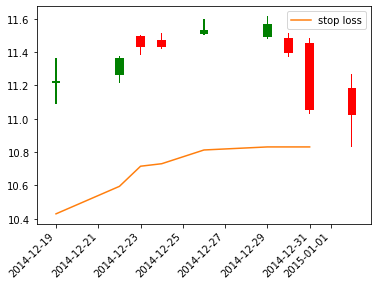

trade 31
entry: [11.015000343322754]
cost_basis: 11.015000343322754
exit: 10.380000750223795
returns: -0.05764862217947119


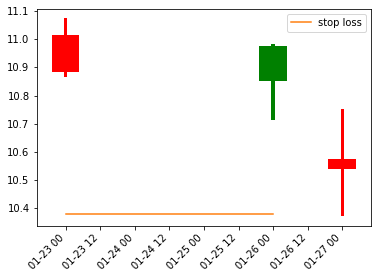

trade 32
entry: [10.833333015441896]
cost_basis: 10.833333015441896
exit: 11.342222213745115
returns: 0.04697438891409001


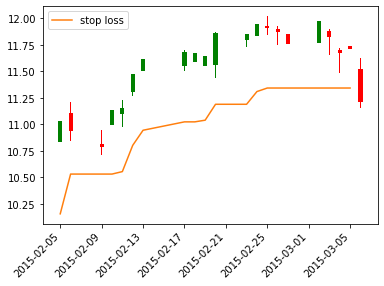

trade 33
entry: [11.58666706085205]
cost_basis: 11.58666706085205
exit: 10.986666361490885
returns: -0.05178371797601679


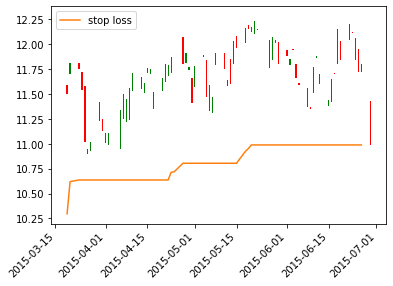

trade 34
entry: [11.648332595825195]
cost_basis: 11.648332595825195
exit: 11.501113255818684
returns: -0.012638662125708494


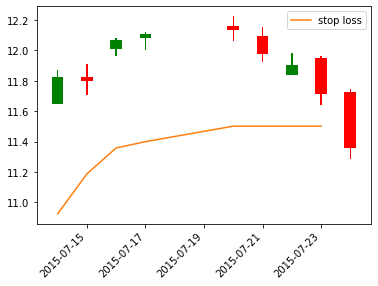

trade 35
entry: [9.793333053588867]
cost_basis: 9.793333053588867
exit: 8.229441960652668
returns: -0.15968936054544733


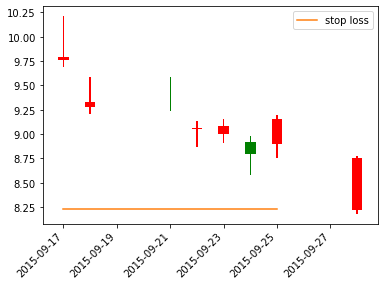

trade 36
entry: [9.62833309173584]
cost_basis: 9.62833309173584
exit: 10.799997965494795
returns: 0.12168927503812829


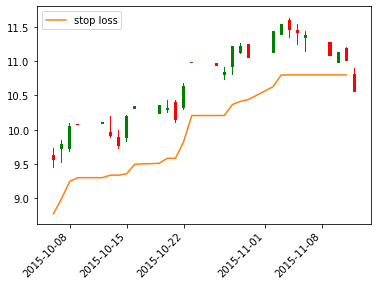

trade 37
entry: [11.248332977294922]
cost_basis: 11.248332977294922
exit: 10.346110661824543
returns: -0.08020942456909304


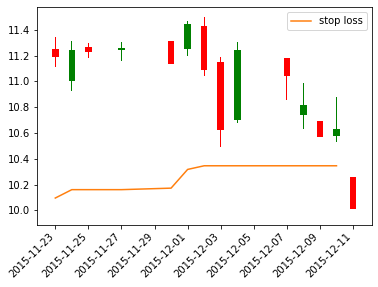

trade 38
entry: [10.94499969482422]
cost_basis: 10.94499969482422
exit: 10.263333002726238
returns: -0.06228110654222637


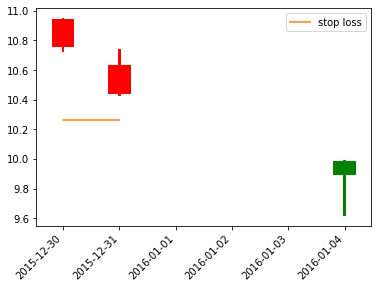

trade 39
entry: [8.311667442321777]
cost_basis: 8.311667442321777
exit: 7.64055633544922
returns: -0.08074325777946306


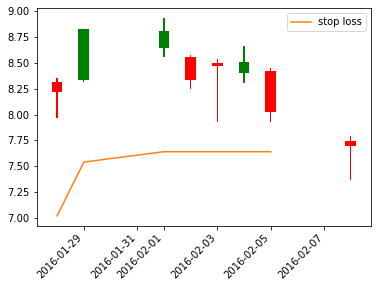

trade 40
entry: [8.680000305175781]
cost_basis: 8.680000305175781
exit: 9.700554211934406
returns: 0.11757533074625363


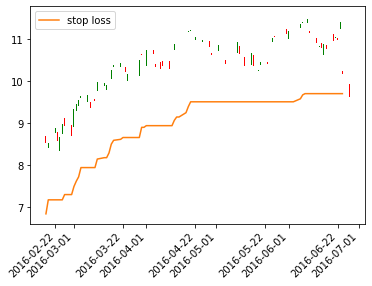

trade 41
entry: [11.351667404174805]
cost_basis: 11.351667404174805
exit: 11.891666412353514
returns: 0.04757001671667315


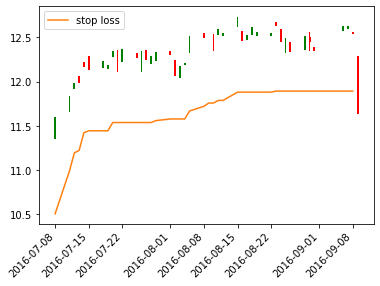

trade 42
entry: [12.395000457763672]
cost_basis: 12.395000457763672
exit: 26.82944583892822
returns: 1.1645377045648642


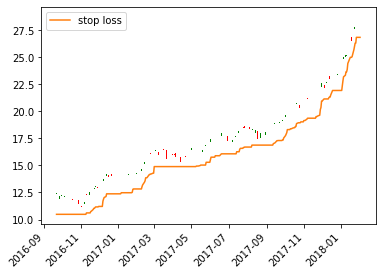

trade 43
entry: [24.11666679382324]
cost_basis: 24.11666679382324
exit: 24.495555877685547
returns: 0.015710673746976895


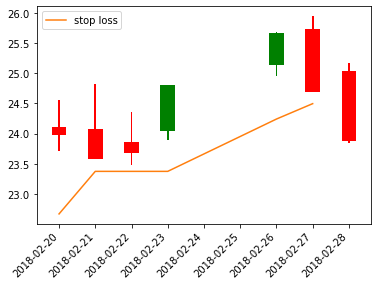

trade 44
entry: [25.918333053588867]
cost_basis: 25.918333053588867
exit: 25.23722076416016
returns: -0.02627917034712211


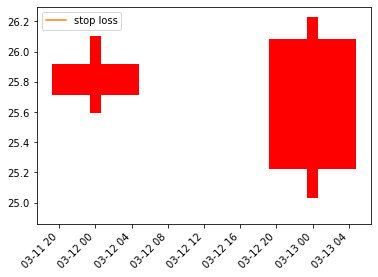

trade 45
entry: [25.50833320617676]
cost_basis: 25.50833320617676
exit: 24.466110865275073
returns: -0.040858112228568395


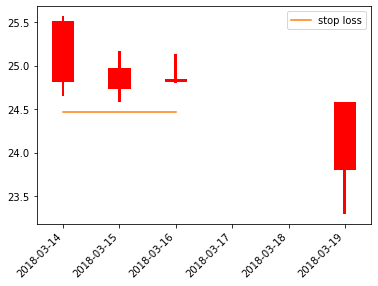

trade 46
entry: [22.61166763305664]
cost_basis: 22.61166763305664
exit: 22.23777898152669
returns: -0.016535209060978353


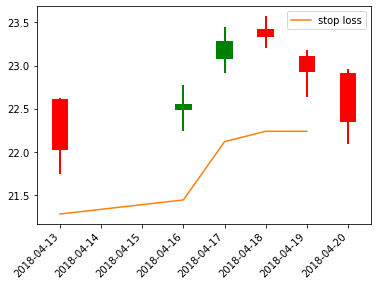

trade 47
entry: [23.15999984741211]
cost_basis: 23.15999984741211
exit: 23.13444328308106
returns: -0.0011034786053293873


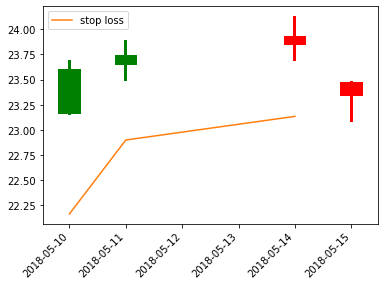

trade 48
entry: [23.31666755676269]
cost_basis: 23.31666755676269
exit: 22.94444465637208
returns: -0.015963812130719873


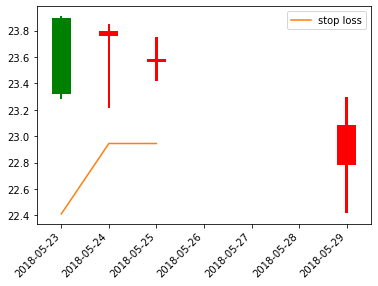

trade 49
entry: [24.1299991607666]
cost_basis: 24.1299991607666
exit: 24.47222073872884
returns: 0.014182411515316695


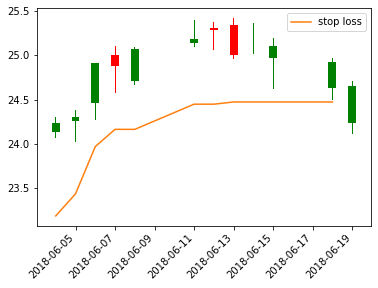

trade 50
entry: [24.799999237060547]
cost_basis: 24.799999237060547
exit: 25.97833061218261
returns: 0.047513363361769465


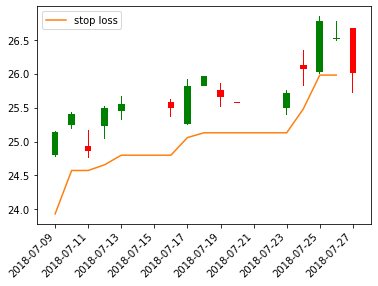

trade 51
entry: [27.065000534057617]
cost_basis: 27.065000534057617
exit: 26.102221806844074
returns: -0.03557283237449107


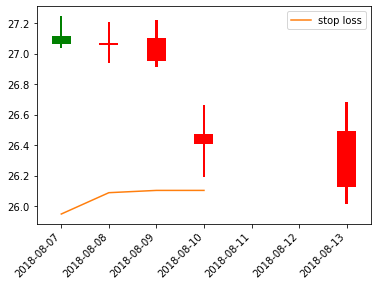

trade 52
entry: [27.225000381469727]
cost_basis: 27.225000381469727
exit: 27.723889032999672
returns: 0.01832465177372436


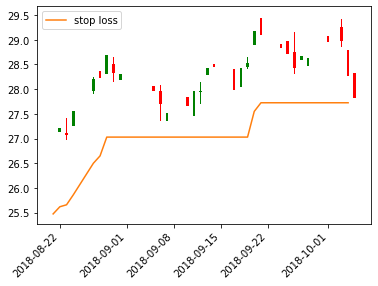

trade 53
entry: [23.09000015258789]
cost_basis: 23.09000015258789
exit: 20.07999992370605
returns: -0.13035947202211187


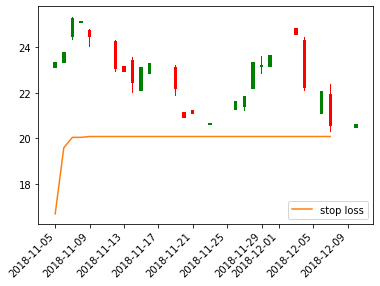

trade 54
entry: [17.84000015258789]
cost_basis: 17.84000015258789
exit: 25.138888676961262
returns: 0.40913051916732107


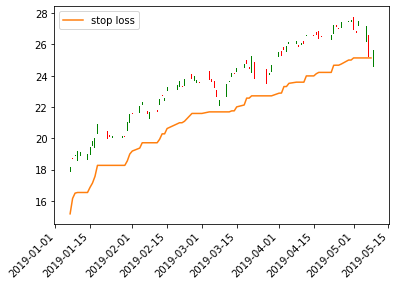

trade 55
entry: [24.96999931335449]
cost_basis: 24.96999931335449
exit: 34.49833297729492
returns: 0.38159126655820436


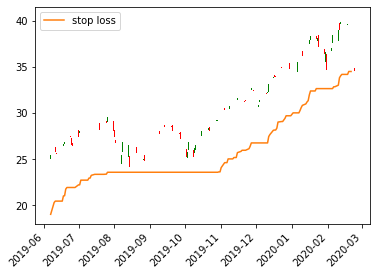

trade 56
entry: [13.1850004196167]
cost_basis: 13.1850004196167
exit: 20.035001754760742
returns: 0.5195298534046751


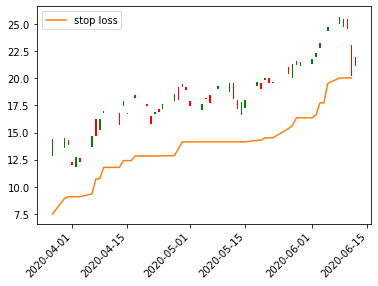

trade 57
entry: [22.170000076293945]
cost_basis: 22.170000076293945
exit: 21.596666971842446
returns: -0.02586076240317908


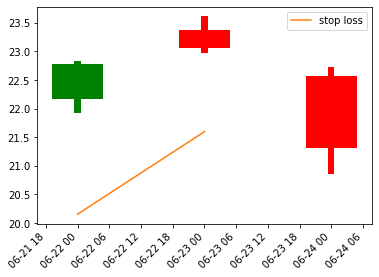

trade 58
entry: [23.88500022888184]
cost_basis: 23.88500022888184
exit: 23.11166826883952
returns: -0.03237730595066957


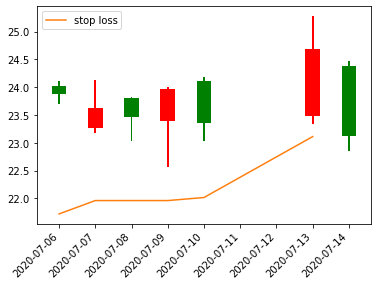

trade 59
entry: [25.190000534057617]
cost_basis: 25.190000534057617
exit: 31.518328348795574
returns: 0.2512238062949571


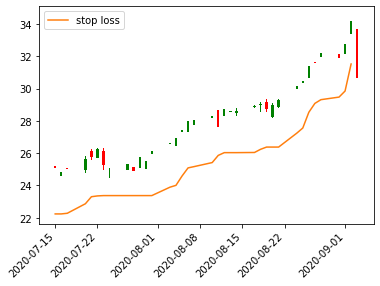

trade 60
entry: [30.850000381469727]
cost_basis: 30.850000381469727
exit: 25.88332811991373
returns: -0.16099423663343818


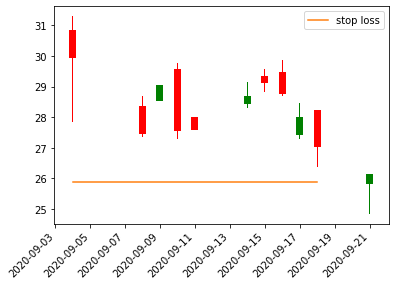

trade 61
entry: [27.524999618530277]
cost_basis: 27.524999618530277
exit: 26.359998067220044
returns: -0.04232521589304347


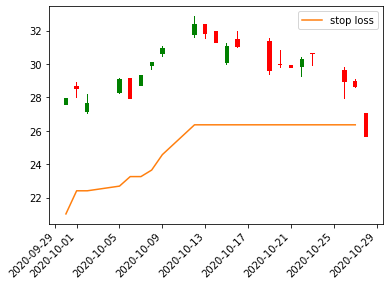

trade 62
entry: [31.209999084472656]
cost_basis: 31.209999084472656
exit: 59.22833506266276
returns: 0.8977358795287359


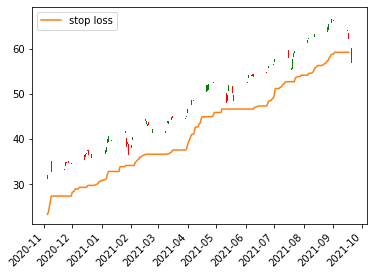

trade 63
entry: [60.935001373291016]
cost_basis: 60.935001373291016
exit: 66.0316670735677
returns: 0.08364102052044352


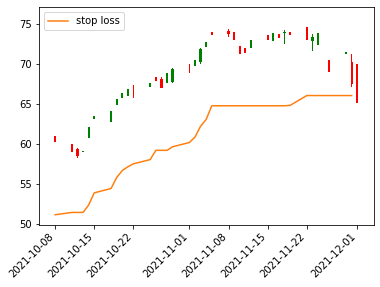

trade 64
entry: [73.04000091552734]
cost_basis: 73.04000091552734
exit: 70.06000010172525
returns: -0.04079957251436156


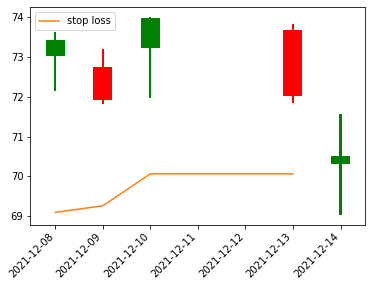

trade 65
entry: [70.2699966430664]
cost_basis: 70.2699966430664
exit: 70.10499318440755
returns: -0.002348135285917079


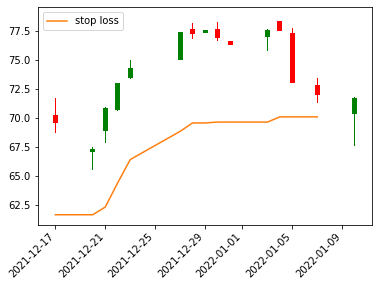

trade 66
entry: [64.54000091552734]
cost_basis: 64.54000091552734
exit: 61.58666737874349
returns: -0.045759738067703136


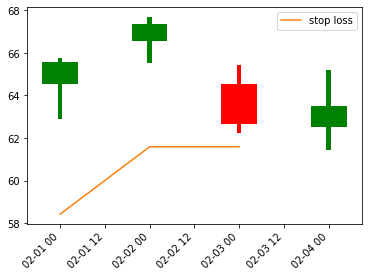

trade 67
entry: [59.290000915527344]
cost_basis: 59.290000915527344
exit: 51.50999704996744
returns: -0.13121949309200323


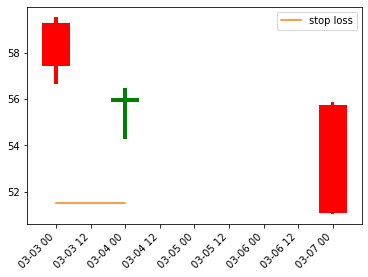

trade 68
entry: [55.9900016784668]
cost_basis: 55.9900016784668
exit: 63.5366694132487
returns: 0.13478598872205927


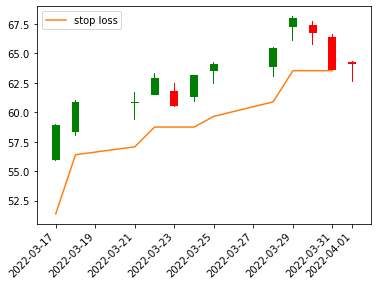

trade 69
entry: [61.959999084472656]
cost_basis: 61.959999084472656
exit: 55.57666524251302
returns: -0.10302346572434527


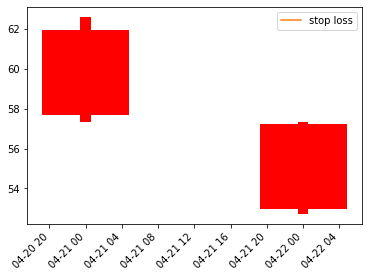

trade 70
entry: [43.81999969482422]
cost_basis: 43.81999969482422
exit: 38.209999084472656
returns: -0.12802374827524668


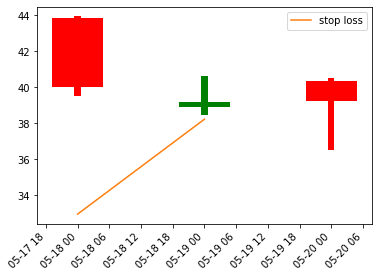

trade 71
entry: [44.86000061035156]
cost_basis: 44.86000061035156
exit: 40.49999745686849
returns: -0.097191330676821


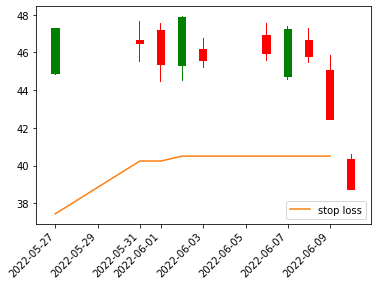

trade 72
entry: [38.959999084472656]
cost_basis: 38.959999084472656
exit: 33.54999923706055
returns: -0.13886036895643158


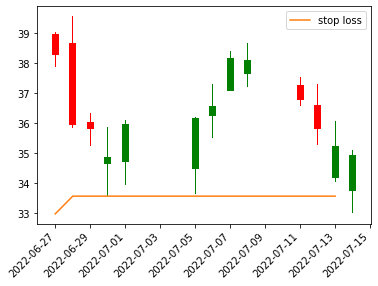

trade 73
entry: [38.93999862670898]
cost_basis: 38.93999862670898
exit: 34.89666748046875
returns: -0.10383490726337374


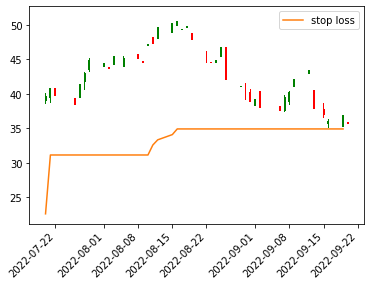

trade 74
entry: [32.2599983215332]
cost_basis: 32.2599983215332
exit: 28.38999938964844
returns: -0.11996277536386538


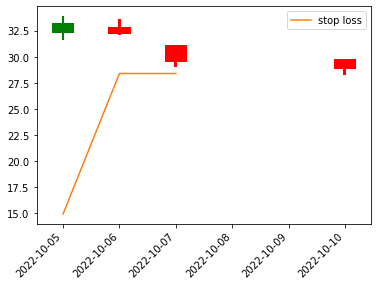

In [ ]:
tl.plot_all_trades()

We can plot the trades that occur over a specific period of time to see how this strategy perform.

No handles with labels found to put in legend.


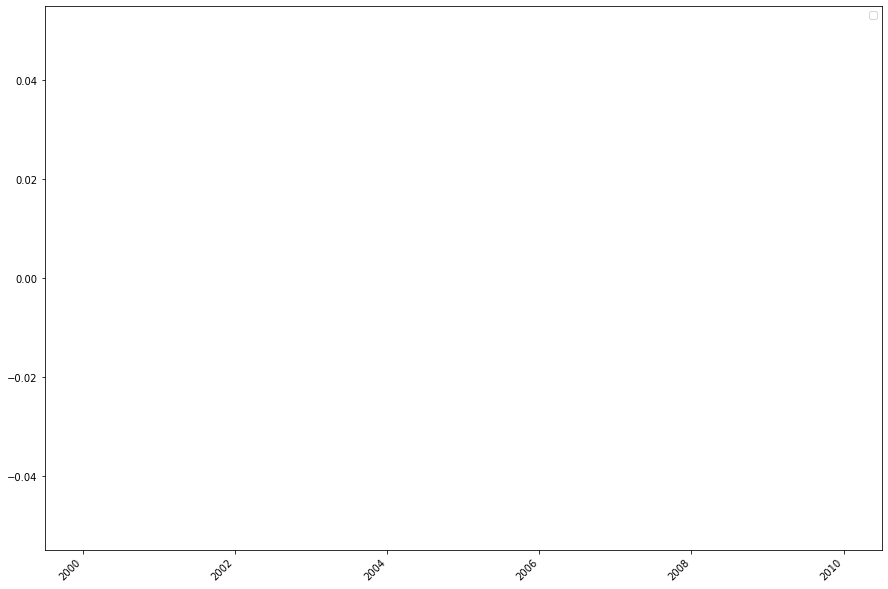

In [ ]:

start_datetime= pd.to_datetime(dt.date(2008, 1, 1))
end_datetime = pd.to_datetime(dt.date(2009, 1, 1))

tl.plot_time_period(df, start_datetime, end_datetime)

We note that the time in trade for winning trades is generally higher than that of losing trades.

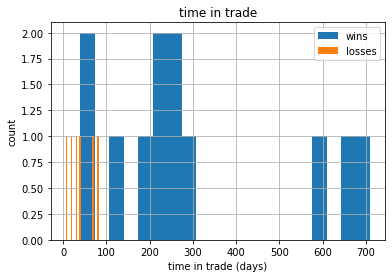

In [ ]:
tl.win_records['time_in_trade'].hist(bins=20, label='wins')
tl.loss_records['time_in_trade'].hist(bins=20, label='losses')
plt.xlabel('time in trade (days)')
plt.ylabel('count')
plt.title('time in trade')
plt.legend()
plt.show()

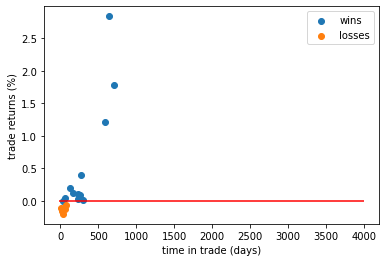

In [ ]:
plt.scatter(tl.win_records['time_in_trade'], tl.win_records['returns'], label='wins')
plt.scatter(tl.loss_records['time_in_trade'], tl.loss_records['returns'], label='losses')
plt.hlines(0, -10, 4000, color='red')
plt.legend()
plt.xlabel('time in trade (days)')
plt.ylabel('trade returns (%)')
plt.show()

### Analysis

We note that the turtle trading rules follow a trend-following or momentum trading strategy. The characteristic of these strategies is greater volatility, with lower win-rate but higher returns per winning trade.

Ideally, the strategy goes long when a long-term upward trend is established and follows the trend until it is exhausted, while avoiding big drawdowns when long-term downward trends are established. 

The downside to this strategy is that short-term volatility is likely to cause whipsaw losses. An example of this is losses when the underlying is trading within a range.

Therefore, the way to optimise this strategy is to pick the underlying to more frequent long-term trends with greater magnitude compared to short-term volatility. It does not matter which direction that long-term trend is in since we can just inverse the rules, e.g. go short when price breaks out under the 20-day low. This is also possibly why the original turtle traders focused on commodity trading, since commodities tend to exhibit trends based on the physical demand and supply of the commodity, whereas equities may be more volatile in the short-term due to speculation.

Another key part to the success of this strategy is to trade diversified and uncorrelated assets so that the various assets will be trending at different times. This will go a long way towards reducing the volatility of a portfolio trading all of these assets.

Another idea is to trade this strategy on leveraged ETFs, for example UPRO (3 x leveraged SP500) instead of trading on SPY. The nature of the ETF (3 x daily returns) is likely to cause the magnitude of long-term trends to increase significantly, thus increasing the returns per winning trade of this strategy. The volatility drag of the leverage should also reduce the number of whipsaw losing trades. Therefore, the overall profitability of this strategy on leveraged ETFs should increase. More testing is required however, since we have to account for a higher expense ratio, tracking error, and a lack of historical data since these ETFs are a relatively recent invention.